<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/lensing/notebooks/Denise_lightcone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
sys.path.insert(0,'/Users/dl264294/Desktop/github/flowpm/')
sys.path.insert(0,'/Users/dl264294/Desktop/github/DifferentiableHOS/')
from DifferentiableHOS.angular_power_tf import measure_power_spectrum_tf
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import z2a,a2z,a_of_chi,rad_comoving_distance
from flowpm.raytracing import  lightcone, Born, wlen, cons, A, nbar_
from flowpm.cosmo_Plank15 import cosmo_15 as cosmo
from flowpm.tfpower import linear_matter_power
import flowpm.constants as constants
import flowpm  
from astropy.io import fits
import time
start_time = time.time()

Populating the interactive namespace from numpy and matplotlib


In [2]:
nc=[64,64,640]   # size of the cube, number of cells
nc_xy= 64                # number of pixel for x and  y 
Boxsize=[200,200,2000]          # Physical size of the cube

In [ ]:
#To make lens planes of size 200 Mpc/h :
r = np.linspace(0,2000,10, endpoint=True)
a = a_of_chi(cosmo, r) 

Text(0.5, 0, 'Mpc/h')

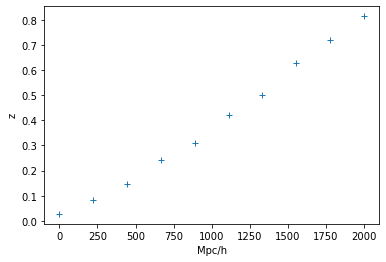

In [4]:
# This allows us to go to roughly z=1
plot(r,a2z(a), '+')
ylabel(r'z')
xlabel(r'Mpc/h')

In [5]:
# We will first run the simulation to the lowest scaler factor entering the lightcone
init_stages = tf.linspace(0.1, a[-1], 4)
initial_conditions = flowpm.linear_field(nc,    
                                            Boxsize, 
                                             lambda k: tf.cast(linear_matter_power(cosmo, k), tf.complex64),         
                                             batch_size=1)
# Sample particles
state = flowpm.lpt_init(initial_conditions, 0.1,cosmo)   
# Evolve particles down to z=0
med_state = flowpm.nbody(state, init_stages, nc,cosmo)         
# Retrieve final density field
med_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), med_state[0])

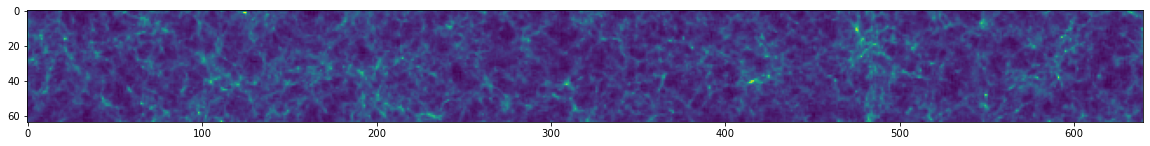

In [6]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, nc).numpy().sum(axis=0))

In [8]:
final_state, lps_a, lps = lightcone(med_state, a[::-1], 
                                  nc, 
                                    5.*60/nc_xy, nc_xy,cosmo)

In [ ]:
#Let's define the source's redshift
a_s=z2a(1.00)
ds=rad_comoving_distance(cosmo,a_s)

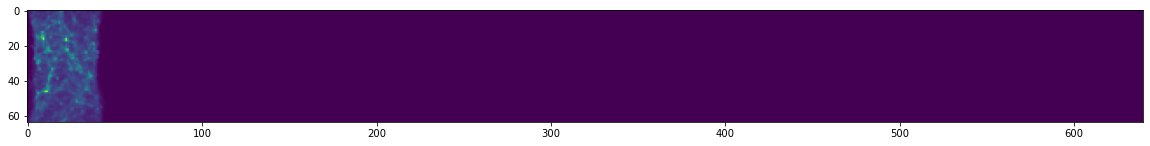

In [11]:
#Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

# And this is what remains of the simulation at redhift=0 
figure(figsize=[20,5])
imshow(tf.reshape(final_field, [nc_xy,nc_xy,-1]).numpy().sum(axis=0)) 

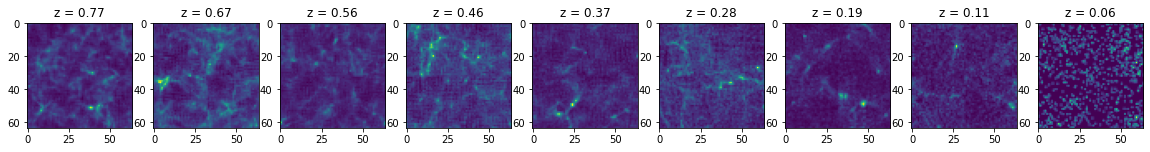

In [12]:
# Here are the lens planes exported during the simulation
figure(figsize=(20,5))
for i in range(len(lps_a)):
    subplot(1,9,i+1)
    imshow(lps[i][0]);
    title('z = %0.2f'%a2z(lps_a[i]))


In [ ]:
final_state.shape   # tensor of shape (3, batch_size, npart, 3)

In [ ]:
k_map=Born(lps_a,lps,ds,nc,Boxsize,nc_xy,5.,cosmo)

In [14]:
c1 = fits.Card('H0', cosmo['H0'], 'Hubble constant in km/s/( h^{-1} Mpc)')  
c2 = fits.Card('hierarch h', cosmo['h'], 'Unitless Hubble constant ')  
c3=fits.Card('W0', cosmo['w0'], 'First order term of dark energy equation')
c4=fits.Card('WA', cosmo['wa'], 'Second order term of dark energy equation of state')
c5=fits.Card('Z', 1.00, ' Redshift of the background sources ')
c6=fits.Card('ANGLE', 5., 'Side angle in degrees  ')
c7=fits.Card('OMEGA_M', cosmo['Omega0_m'], ' Dark Matter density')
c8=fits.Card('OMEGA_L', cosmo['Omega0_de'], 'Dark Energy density ')
c9=fits.Card('ITYPE', 'ConvergenceMap', 'Image type ')


In [15]:
for i in range(len(lps_a)):
    plan=fits.PrimaryHDU(lps[i][0])
    plans = fits.HDUList([plan])
    for j in range(1,9):
        exec(f'plan.header.append(c{j})')
    plan.header.append(fits.Card('CHI', r[i], 'Comoving distance in Mpc/h')) 
    hdul = fits.HDUList([plan])
    plans.writeto('export_lens_plans'+str(i)+'.fits')
    

In [ ]:
hdu = fits.PrimaryHDU(k_map)
for i in range(1,10):
    exec(f'hdu.header.append(c{i})')
hdul = fits.HDUList([hdu])
hdul.writeto('export_lens.fits')

In [18]:
time.time() - start_time

1184.3307888507843

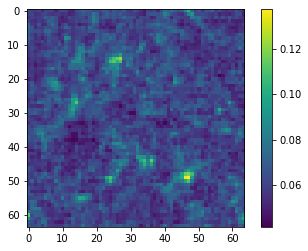

In [20]:
imshow(k_map)
colorbar()
#savefig('kmap_denise_z1.png',dpi=100)


In [ ]:
#begin the computation of power spectrum from the map

In [31]:
#ell = 2. * np.pi * k / pixel_size / 512
ell, ps_example = measure_power_spectrum_tf(tf.cast(k_map,dtype=tf.complex64),5.,64)


Text(0, 0.5, '$C_{\\ell}$')

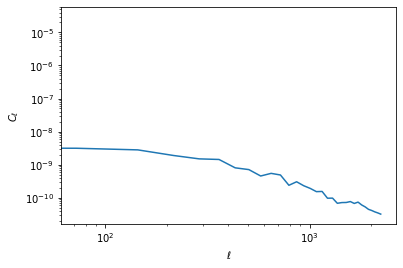

In [24]:

loglog(ell, ps_example)
xlabel('$\ell$')
ylabel('$C_{\ell}$')

In [ ]:
#begin computation power spectra from theory 

In [25]:
import jax
import jax_cosmo as jc

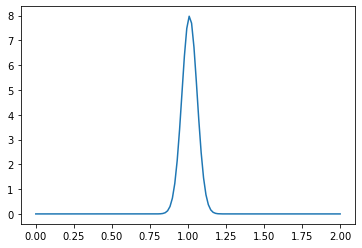

In [26]:
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
plot(zsamp, nzs_s(zsamp))

In [27]:
nzs = [nzs_s]

In [28]:
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

In [29]:
elle = np.logspace(1,4) # Defines a range of \ell
cosmo_jc = jc.Planck15()
# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo_jc, elle, probes)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Populating the interactive namespace from numpy and matplotlib


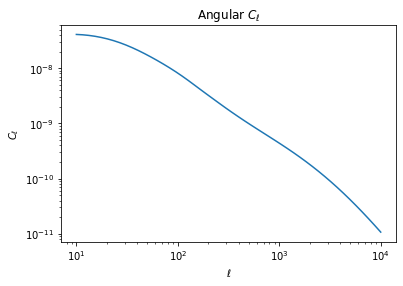

In [30]:

%pylab inline 
loglog(elle, cls[0])
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');

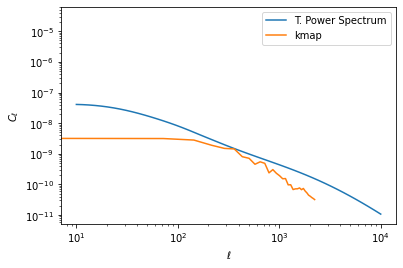

In [32]:
loglog(elle, cls[0],label='T. Power Spectrum')
loglog(ell, ps_example,label='kmap')
ylabel(r'$C_\ell$')
xlabel(r'$\ell$')
legend()
# #savefig('power_con128_z=0.99.png',dpi=80)

In [ ]:
 print("--- %d seconds ---(%d minutes)" % ((time.time() - start_time),(time.time() - start_time)/60.))